### Reconstruction of simulated nanoparticles using the Deep Image Prior approach

*This notebook presents the reconstruction of simulated nanoparticles.The data set consists of 600 2D images from simulated nanoparticles. The nanoparticles were already forward projected using tomosipo's Radon transform (0°:1°:180°), and reconstructed with limited number of projections in three scenarios using SIRT algorithm to mimic scenario from possibly real experimental acquisitions of nanoparticles :*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

#### The DIP formulation adapted to tomography consists of solving the following problem :

$$ \hat{\theta} = \underset{\theta}{\arg\min} \left\| P F_{\theta}(z) - y \right\|_2^2 $$

Where :
- $ F_{\theta} $ is the network and weights to optimized
- $ P $ is the forward operator (Radon transform)
- $ z $ is an input noise
- $ y $ are the acquired projections

*The method is applied to a 2D sinogram in order to reconstruct a 2D image.*

In [1]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the simulated nanoparticles image to be reconstructed

The 50 images from the test dataset used in the supervised approach are loaded. (*test_data*)

The image to reconstruct is chosen with the **data_index** value (between 0 and 50) and the acquisition scenario is chosen with **ACQUISITION_CASE**.
The full sinogram (-90°:1°:+90°) is computed as a reference and the degraded sinogram is obtained based on the chosen acquisition case.

In [2]:
data_index = 15

test_data = imread('../../Data/Simulated/simu_full.tif')[-50:,:,:][data_index]
rad_op = Radon2D(angle=np.deg2rad(np.arange(0.,180.,1.)), size=512)

reference_sirt = normalize(torch.from_numpy(test_data).type(dtype))
reference_sino = normalize(rad_op.forward(reference_sirt))

ACQUISITION_CASE = 3
SELECT = {
    1: [reference_sino[27:151:2], np.arange(27.,151.,2.)],
    2: [reference_sino[27:151:10], np.arange(27.,151.,10.)],
    3: [reference_sino[57:119:2], np.arange(57.,119.,2.)],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
THETA = SELECT[ACQUISITION_CASE][1]

degraded_sirt = Radon2D(angle=np.deg2rad(THETA), size=512).backward_sirt_ts(degraded_sino)

Text(0.5, 1.0, 'Degraded sinogram (missing projections)')

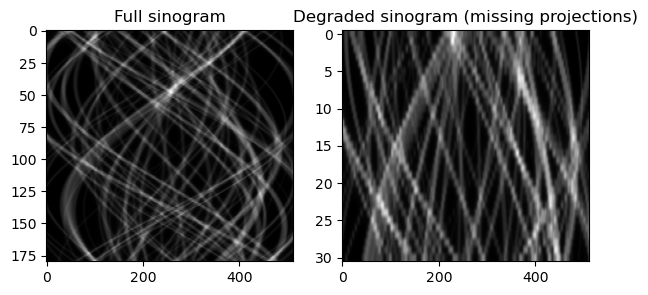

In [3]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (7,3))

ax0.imshow((simplify(reference_sino)), aspect='auto')
ax0.set_title('Full sinogram')
ax1.imshow(simplify(degraded_sino), aspect='auto')
ax1.set_title('Degraded sinogram (missing projections)')

#### Setup of the network and DIP parameters

The parameters are set with the values from the article.

- *NUM_ITER* : Number of training iterations (empirical choice)
- *LR* : optimization learning rate
- *INPUT_DEPTH* : Depth size of the input noise
- *STD_INP_NOISE* : Range of the input noise
- *NOISE_REG* : Per iteration regularization value on the input noise (from original DIP implementation (D. Ulyanov et al.))

For the DIP method :
- A possible TV weight can be added to add a TV regularization (*TV_WEIGHT*)

In [4]:
NUM_ITER = 3000
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.
TV_WEIGHT = 0.0 # Optionnal

In [5]:
n_scale = 4
ud_filters=[16,32,64,128]
skip_filters=[4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH, output_shape=1,
                     down_filters=ud_filters, up_filters=ud_filters, skip_filters=skip_filters,
                     down_kernels=[3]*n_scale, up_kernels=[3]*n_scale, skip_kernels=[1]*n_scale,
                     up_mode='bilinear', down_mode='stride', pad_mode='zeros',
                     ).to('cuda').type(dtype)

  0%|          | 0/3000 [00:00<?, ?it/s]/nobackup/sb272614/Environments/env_tomo/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([31, 512])) that is different to the input size (torch.Size([1, 1, 31, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


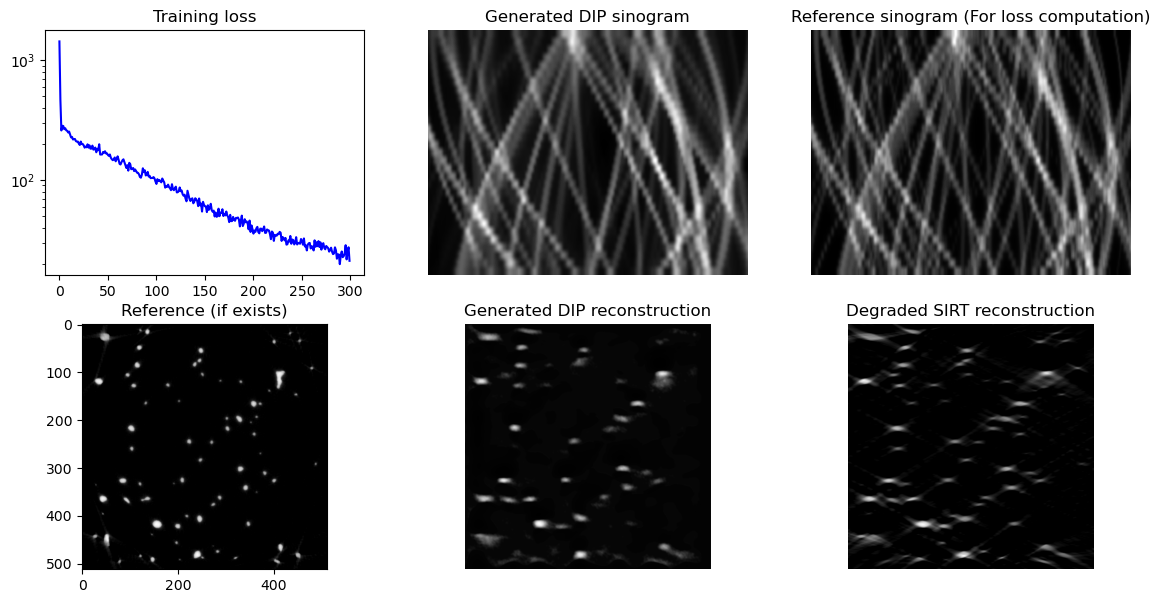

 11%|█         | 318/3000 [00:12<01:48, 24.73it/s]


KeyboardInterrupt: 

In [6]:
output = dip_reconstruction(NUM_ITER, LR, 512, STD_INP_NOISE, NOISE_REG,
                            np.flip(THETA), INPUT_DEPTH,
                            degraded_sino, degraded_sirt, reference_sirt, network, DISPLAY=True,
                            SHOW_EVERY=100, tv_weight=TV_WEIGHT)

best_loss   = output['best_loss']
best_output = output['best_output']
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']

#### Comparison of the results and computation of image quality metrics.

NameError: name 'degraded_sirt' is not defined

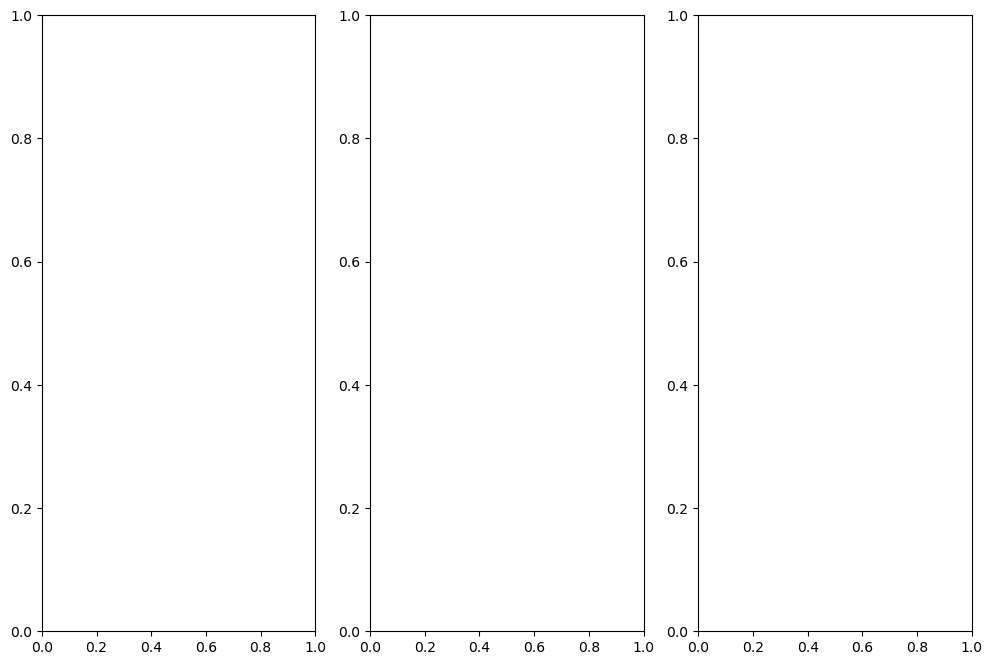

In [ ]:
fig, ((ax0, ax1, ax2)) = plt.subplots(1, 3, figsize = (12,8))
ax0.imshow(simplify(degraded_sirt))
ax0.set_title('Degraded SIRT reconstruction')
ax1.imshow(simplify(best_output))
ax1.set_title('DIP reconstruction')
ax2.imshow(simplify(reference_sirt))
ax2.set_title('SIRT reference reconstruction')

In [ ]:
# Computation of image quality metrics on the SIRT reconstruction and the restored images

ref = to8bit(reference_sirt)
sirt = to8bit(degraded_sirt)
dip = to8bit(best_output)

ssim_sirt = ssim(ref, sirt)
psnr_sirt = psnr(ref, sirt)
ssim_dip = ssim(ref, dip)
psnr_dip = psnr(ref, dip)

print('Degraded SIRT')
print(f'SSIM: {ssim_sirt:.4f} - PSNR: {psnr_sirt:.4f}')
print('Restored')
print(f'SSIM: {ssim_dip:.4f} - PSNR: {psnr_dip:.4f}')

Degraded SIRT
SSIM: 0.7490 - PSNR: 24.3880
Restored
SSIM: 0.7938 - PSNR: 24.4513
